In [45]:
import gurobipy as gp
import numpy as np
import pandas as pd
import re

model = gp.Model()

## Sets

In [46]:
node_types = pd.read_csv('nodes.csv',)
N = set(node_types['Names'])
Ni = set(node_types['Names'])
N_D = set()
N_S = set()
N_B = set()
for index, data in node_types.iterrows():
    if data['Demand'] != 0:
        N_D.add(data['Names'])
    if data['Supply'] != 0:
        N_S.add(data['Names'])
    if data['Battery'] != 0:
        N_B.add(data['Names'])

Length_Nodes = len(N)
Length_Positions = 18

Positions = set()
for i in range(Length_Positions):
    my_str = "Position_" + str(i+1)
    Positions.add(my_str)

TF = set({"Position_1"})

WH = set({"node_16"})
DummyWH = set({"node_17"})

node_types.set_index('Names', inplace=True)

## Parameters

In [47]:
distances = pd.read_csv('trivialdistances_TL.csv',index_col=0)
Demand = pd.DataFrame(columns=['Demand'])
Supply = pd.DataFrame(columns=['Supply'])
Battery = pd.DataFrame(columns=['Battery'])
for data in N_D:
    Demand.loc[data] = node_types.loc[data,'Demand']
for data in N_S:
    Supply.loc[data] = node_types.loc[data,'Supply']
for data in N_B:
    Battery.loc[data] = node_types.loc[data,'Battery']

BatterySupply = np.sum(Battery['Battery'])
BatteryCapacity = 70
ScooterCapacity = 20
A_LoadingTime = 1.2
A_UnloadingTime = 1.2
A_BatteryChangeTime = 0.5

Nodes:
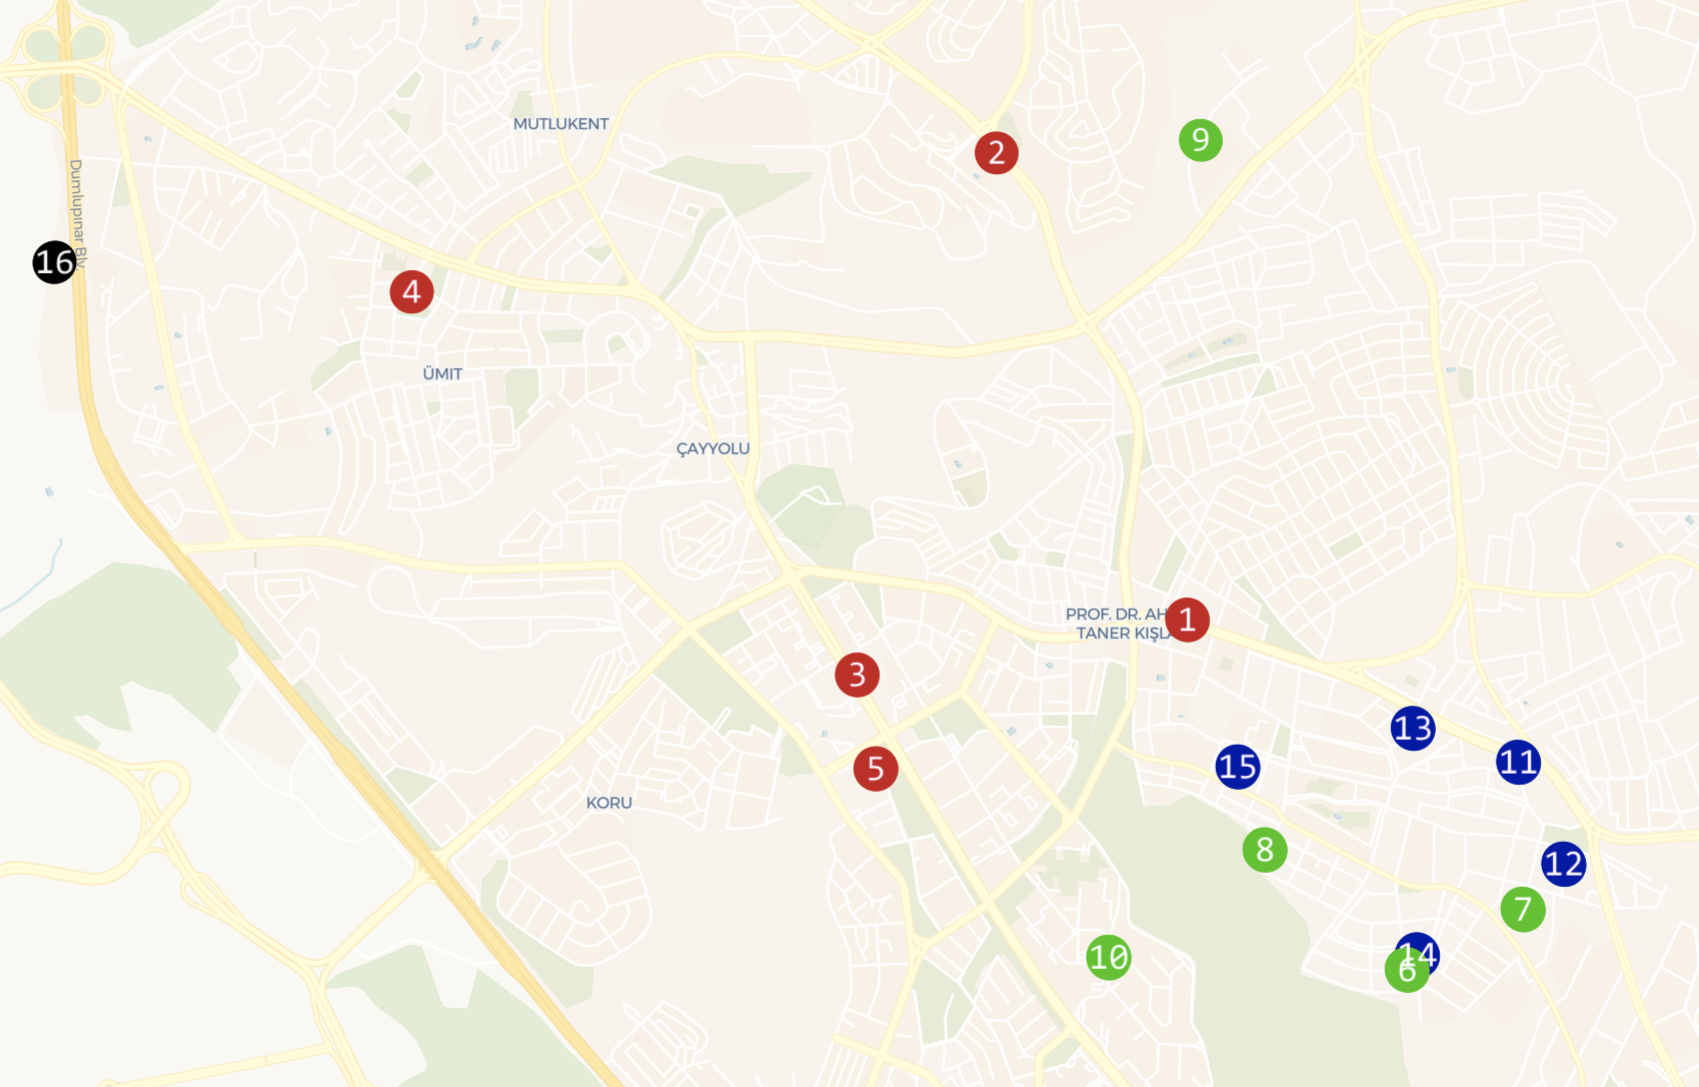

## Variables

### 'Node to position assignment' (BINARY)

In [48]:
x = {}
for node in N:
    for position in Positions:
        x[(node,position)] = model.addVar(vtype=gp.GRB.BINARY, name=f'x_{node}_{position}')

### 'Arc to position assignment'

In [49]:
w = {}
for node in N:
    for node_i in Ni:
        for position in Positions:
            w[(node,node_i,position)] = model.addVar(lb=0, name=f'w_{node}_{node_i}_{position}')

### 'Number of scooters left to node i at position t'

In [50]:
y = {} 
for node in N_D:
    for position in Positions:
        y[(node,position)] = model.addVar(lb=0, name=f'Y_{node}_{position}')

 ### 'Number of scooters taken from node i at position t'

In [51]:
z = {} 
for node in N_S:
    for position in Positions:
        z[(node,position)] = model.addVar(lb=0, name=f'z_{node}_{position}')

### 'Number of scooters in the vehicle after leaving node'

In [52]:
LS = {}
for position in Positions:
    LS[(position)] = model.addVar(lb=0, name=f'LS_{position}')

### 'Amount of unmet scooter demand at node i'

In [53]:
UD = {} 
for node in N_D:
    UD[(node)] = model.addVar(lb=0, name=f'UD_{node}')

### 'Amount of taken charged battery from WH at posiiton T'

In [54]:
U = {}
for node in WH:
    for position in Positions:
        U[(node,position)] = model.addVar(lb=0, name=f'U_{node}_{position}')

### 'Amount of battery change at node i at position t'

In [55]:
V = {}
for node in N_B:
    for position in Positions:
        V[(node,position)] = model.addVar(lb=0, name=f'V_{node}_{position}')

### 'Number of battery in the vehicle after leaving position t'

In [56]:
LB = {}
for position in Positions:
    LB[(position)] = model.addVar(lb=0, name=f'LB_{position}')

### 'Amount of unmet battery demand at node i'

In [57]:
UB = {}
for node in N_B:
    UB[(node)] = model.addVar(lb=0, name=f'UB_{node}')

### 'Amount of supply from battery changed scooter'

In [58]:
BSS = {}
for node in N_B:
    for position in Positions:
        BSS[(node,position)] = model.addVar(lb=0, name=f'BCC_{node}_{position}')

### 'Position fitting variable'

In [59]:
tmax = {}
for node in N:
    tmax[(node)] = model.addVar(lb=0, name=f'tmax_{node}')

## Objective Function

In [60]:
OPCost_RELLOC = 32.1765
OPCost_BATCHANGE = 32.1765/2
TMAX_PARAM = 0.01

model.setObjective(TMAX_PARAM*gp.quicksum(tmax[(node)] for node in WH) + OPCost_RELLOC*gp.quicksum(UD[(node)] for node in N_D)
                            + OPCost_BATCHANGE*gp.quicksum(UD[(node)] for node in N_D)  
                            + gp.quicksum((distances.loc[node, node_1]*w[(node,node_1,position)]) for position in Positions for node_1 in Ni for node in N), 
                            sense=gp.GRB.MINIMIZE)

Objective function includes maximum position number, amount of unmet demand, amount of scooters batteries not changed and transportation cost. All these cost are calculated as cost (TL).

## Constraints

### 'For creating arcs between positions'

In [61]:
for node in N:
    for node_1 in Ni:
        for position in Positions:
            my_str = position
            numeric_part = re.search(r'\d+', my_str).group()
            numeric_int = int(numeric_part)
            numeric_int += 1
            position_plus = "Position_" + str(numeric_int)
            if numeric_int <= Length_Positions:
                model.addConstr(w[(node, node_1, position)] >= (x[(node, position)] + x[(node_1, position_plus)] - 1), 
                                name=f'R_1_{node}_{node_1}_{position}')

### 'Node 1 is warehouse.  Vehicle is always start from warehouse.'

In [62]:
for node in WH:
    for position in TF:
        model.addConstr(x[(node, position)] == 1, name=f'R_2_{node}_{position}')

### 'Maximum one node can be visited at position t.'

In [63]:
for position in Positions:
    model.addConstr(gp.quicksum(x[(node, position)] for node in N) <= 1, name=f'R_3_{node}_{position}')

### 'Warehouse is last position and update TMAX'

In [64]:
for node in N:
    for warehouse in WH:
        my_str = node
        numeric_part = re.search(r'\d+', my_str).group()
        numeric_int = int(numeric_part)
        if (numeric_int <= Length_Nodes-2):
            model.addConstr(tmax[(warehouse)] >= (tmax[(node)] + 1), name=f'LW_{node}_{warehouse}')

### 'TMAX is Last Position'

In [65]:
for node in N:
    for position in Positions:
        my_str = position
        numeric_part = re.search(r'\d+', my_str).group()
        numeric_int = int(numeric_part)
        model.addConstr(tmax[(node)] >= (numeric_int*x[(node, position)]), name=f'LP_{node}_{position}')

### 'Unmet Demand of node i is equal or greater than the scooter demand minus unloaded scooter for each node i.'

In [66]:
for node in N_D:
    model.addConstr(UD[(node)] >= (Demand.loc[node,"Demand"] - gp.quicksum(y[(node, position)] for position in Positions)), name=f'RL_1_{node}_{position}')

### 'Left Scooter Balance Equation'

In [67]:
for position in Positions:
    my_str = position
    numeric_part = re.search(r'\d+', my_str).group()
    numeric_int = int(numeric_part)
    numeric_int += -1
    position_minus = "Position_" + str(numeric_int)
    if numeric_int >= 1:
        model.addConstr((gp.quicksum(z[(node,position)] for node in N_S) - gp.quicksum(y[(node,position)] for node in N_D) + LS[(position_minus)] + 
                                                    gp.quicksum(BSS[(node,position)] for node in N_B)) == LS[(position)], name=f'RL_2_{position}')
    else:
        model.addConstr((gp.quicksum(z[(node,position)] for node in N_S) - gp.quicksum(y[(node,position)] for node in N_D) 
                         + gp.quicksum(BSS[(node,position)] for node in N_B)) == LS[(position)], name=f'RL_2_{position}')

### 'The number of scooters in the vehicle cannot exceed the vehicle capacity for each position.'

In [68]:
for position in Positions:
    model.addConstr(LS[(position)] <= ScooterCapacity, name=f'RL_3_{position}')

### 'The total number of scooters taken from node i cannot exceed the supply of node i.' 

In [69]:
for node in N_S:
    model.addConstr(gp.quicksum(z[(node,position)] for position in Positions)  <=  Supply.loc[node, "Supply"], name=f'RL_4_{node}')    

### 'More scooters than requested cannot be left on the node i.'

In [70]:
for node in N_D:
    model.addConstr(gp.quicksum(y[(node,position)] for position in Positions) <= Demand.loc[node, "Demand"], name=f'RL_5_{node}')

 ### 'If vehicle is not at node i at position t, then number of scooters taken from node i at position t must be 0.'

In [71]:
for node in N_S:
    for position in Positions:
        model.addConstr(z[(node,position)] <= (Supply.loc[node, "Supply"] * x[(node,position)]), name=f'RL_6_{node}_{position}')

### 'If vehicle is not at node i at position t, then number of scooters left to node i at position t must be 0.'

In [72]:
for node in N_D:
    for position in Positions:
        model.addConstr(y[(node,position)] <= (Demand.loc[node, "Demand"] * x[(node,position)]), name=f'RL_7_{node}_{position}')

### 'Vehicle has to turn warehouse'

In [73]:
for node in DummyWH:
    model.addConstr(gp.quicksum(x[(node,position)] for position in Positions) == 1, name=f'WH_1_{node}')

### 'Warehouse has to be last node visited.'

In [74]:
for node in WH:
    for node_1 in DummyWH:
        sum = 0
        for position in Positions:
                my_str = position
                numeric_part = re.search(r'\d+', my_str).group()
                numeric_int = int(numeric_part)
                sum += (numeric_int * x[(node_1,position)])
        model.addConstr(tmax[(node)] == sum, name=f'WH_2_{node}_{node_1}')

### 'Vehicle can't jump over position'

In [75]:
for node in N:
    for position in Positions:
        my_str = position
        numeric_part = re.search(r'\d+', my_str).group()
        numeric_int = int(numeric_part)
        numeric_int += 1
        position_plus = "Position_" + str(numeric_int)
        if numeric_int <= Length_Positions:
            model.addConstr((x[(node, position)] + x[(node, position_plus)]) <= 1, name=f'WH_3_{node}_{position}')

### 'Vehicle can't stay at same node'

In [76]:
for position in Positions:
    my_str = position
    numeric_part = re.search(r'\d+', my_str).group()
    numeric_int = int(numeric_part)
    numeric_int += 1
    position_plus = "Position_" + str(numeric_int)
    if numeric_int <= Length_Positions:
        model.addConstr(gp.quicksum(x[(node, position)] for node in N) >= gp.quicksum(x[(node, position_plus)] for node in N), name=f'WH_4_{position}')

### 'More batteries than requested cannot be changed on the node i'

In [77]:
for node in N_B:
    model.addConstr(gp.quicksum(V[(node, position)] for position in Positions) <= Battery.loc[node, "Battery"], name=f'B_1{position}')

### 'If vehicle is not at node i at position t, then number of batteries changed at node i at position t must be 0.'

In [78]:
for node in N_B:
    for position in Positions:
        model.addConstr(V[(node, position)] <= (Battery.loc[node, "Battery"]*x[(node,position)]), name=f'B_2_{node}_{position}')

### 'Batteries can be taken with maximum amount of 70, when visiting the only depot node.'

In [79]:
for node in WH:
    for position in Positions:
        model.addConstr(U[(node, position)] <= (BatteryCapacity*x[(node,position)]), name=f'B_3_{node}_{position}')

### 'Battery Balance Equation'

In [80]:
for node in WH:
    for position in Positions:
        my_str = position
        numeric_part = re.search(r'\d+', my_str).group()
        numeric_int = int(numeric_part)
        numeric_int += -1
        position_minus = "Position_" + str(numeric_int)
        if numeric_int >= 1:
            model.addConstr(LB[(position)] == (LB[(position_minus)] - gp.quicksum(V[(node_1, position)] for node_1 in N_B) + 
                                                                            U[(node, position)]), name=f'B_4_{node}_{position}')
        else:       
            model.addConstr(LB[(position)] == (U[(node, position)] - gp.quicksum(V[(node_1, position)] for node_1 in N_B)), name=f'B_4_{node}_{position}')

### 'Unmet battery demand is equal or greater than the battery demand minus total changed battery for each node i.'

In [81]:
for node in N_B:
    model.addConstr(UB[(node)] >= (Battery.loc[node, "Battery"] -  gp.quicksum(V[(node, position)] for position in Positions)), name=f'B_5_{node}')

### 'Amount of battery cannot exceed the capacity of vehicle'

In [82]:
for position in Positions:
    model.addConstr(LB[(position)] <= BatteryCapacity, name=f'B_6_{position}')

### 'Time decreasing constraint first'

In [83]:
for node in N_D:
    for position in Positions:
        my_str = position
        numeric_part = re.search(r'\d+', my_str).group()
        numeric_int = int(numeric_part)
        numeric_int += 1
        position_plus = "Position_" + str(numeric_int)
        my_str_node = node
        numeric_part_node = re.search(r'\d+', my_str_node).group()
        numeric_int_node = int(numeric_part_node)
        if numeric_int <= Length_Positions:
            if (numeric_int_node) >= 11:
                model.addConstr(x[(node,position_plus)] <= (Demand.loc[node,"Demand"]*LS[(position)] + LB[(position)]*Battery.loc[node,"Battery"]), 
                                                                                                                    name=f'MUZE_1_{node}_{position}')
            else:
                model.addConstr(x[(node,position_plus)] <= (Demand.loc[node,"Demand"]*LS[(position)]), name=f'MUZE_1_{node}_{position}')

'If scooter supply in vehicle is zero or scooter demand in node is zero, x(i,T) must be 0.'

### 'Time decreasing constraint second'

In [84]:
for node in N_S:
    for position in Positions:
        my_str = position
        numeric_part = re.search(r'\d+', my_str).group()
        numeric_int = int(numeric_part)
        numeric_int += 1
        position_plus = "Position_" + str(numeric_int)
        if numeric_int <= Length_Positions:
            model.addConstr((x[(node,position_plus)] + LS[(position)]) <= 20.99, name=f'MUZE_2_{node}_{position}')

'If scooter supply in vehicle is 20 , x(i,T) for supply node must be 0.'

### 'Battery Changed Scooters can be supply'

In [85]:
for position in Positions:
    model.addConstr(gp.quicksum(V[(node,position)] for node in N_B) >= gp.quicksum(BSS[(node,position)] for node in N_B), name=f'BS_{position}')

## Run Model

In [86]:
model.update()
model.optimize()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 6319 rows, 6044 columns and 19631 nonzeros
Model fingerprint: 0x56531660
Variable types: 5738 continuous, 306 integer (306 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [1e-02, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+01]
Found heuristic solution: objective 1351.4330000
Presolve removed 1556 rows and 1424 columns
Presolve time: 0.08s
Presolved: 4763 rows, 4620 columns, 30540 nonzeros
Variable types: 4352 continuous, 268 integer (267 binary)

Root relaxation: objective 1.978949e+01, 1493 iterations, 0.08 seconds (0.12 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd 

## Display Solutions

### Display X

In [87]:
for node in N:
        for position in Positions:
                if x[(node, position)].x >= 1:
                        print(x[(node,position)])

<gurobi.Var x_node_7_Position_7 (value 1.0)>
<gurobi.Var x_node_13_Position_4 (value 1.0)>
<gurobi.Var x_node_16_Position_1 (value 1.0)>
<gurobi.Var x_node_2_Position_3 (value 1.0)>
<gurobi.Var x_node_10_Position_13 (value 1.0)>
<gurobi.Var x_node_4_Position_16 (value 1.0)>
<gurobi.Var x_node_9_Position_2 (value 1.0)>
<gurobi.Var x_node_6_Position_9 (value 1.0)>
<gurobi.Var x_node_1_Position_12 (value 1.0)>
<gurobi.Var x_node_8_Position_10 (value 1.0)>
<gurobi.Var x_node_3_Position_15 (value 1.0)>
<gurobi.Var x_node_12_Position_6 (value 1.0)>
<gurobi.Var x_node_11_Position_5 (value 1.0)>
<gurobi.Var x_node_17_Position_17 (value 1.0)>
<gurobi.Var x_node_14_Position_8 (value 1.0)>
<gurobi.Var x_node_15_Position_11 (value 1.0)>
<gurobi.Var x_node_5_Position_14 (value 1.0)>


### Display W

In [88]:
for node in N:
        for node_1 in Ni:
                for position in Positions:
                        if w[(node, node_1, position)].x >= 1:
                                print(w[(node,node_1,position)])

<gurobi.Var w_node_7_node_14_Position_7 (value 1.0)>
<gurobi.Var w_node_13_node_11_Position_4 (value 1.0)>
<gurobi.Var w_node_16_node_9_Position_1 (value 1.0)>
<gurobi.Var w_node_2_node_13_Position_3 (value 1.0)>
<gurobi.Var w_node_10_node_5_Position_13 (value 1.0)>
<gurobi.Var w_node_4_node_17_Position_16 (value 1.0)>
<gurobi.Var w_node_9_node_2_Position_2 (value 1.0)>
<gurobi.Var w_node_6_node_8_Position_9 (value 1.0)>
<gurobi.Var w_node_1_node_10_Position_12 (value 1.0)>
<gurobi.Var w_node_8_node_15_Position_10 (value 1.0)>
<gurobi.Var w_node_3_node_4_Position_15 (value 1.0)>
<gurobi.Var w_node_12_node_7_Position_6 (value 1.0)>
<gurobi.Var w_node_11_node_12_Position_5 (value 1.0)>
<gurobi.Var w_node_14_node_6_Position_8 (value 1.0)>
<gurobi.Var w_node_15_node_1_Position_11 (value 1.0)>
<gurobi.Var w_node_5_node_3_Position_14 (value 1.0)>


### Display y (scooter left to node i)

In [89]:
for node in N_D:
        for position in Positions:
                if y[(node, position)].x > 0:
                        print(y[(node,position)])

<gurobi.Var Y_node_13_Position_4 (value 1.0)>
<gurobi.Var Y_node_2_Position_3 (value 2.0)>
<gurobi.Var Y_node_4_Position_16 (value 6.0)>
<gurobi.Var Y_node_1_Position_12 (value 5.0)>
<gurobi.Var Y_node_12_Position_6 (value 2.0)>
<gurobi.Var Y_node_3_Position_15 (value 1.0)>
<gurobi.Var Y_node_11_Position_5 (value 2.0)>
<gurobi.Var Y_node_14_Position_8 (value 3.0)>
<gurobi.Var Y_node_15_Position_11 (value 2.0)>
<gurobi.Var Y_node_5_Position_14 (value 4.0)>


### Display Unmet Denamd and Battery Demand

In [90]:
print(gp.quicksum(UD[(node)].x for node in N_D))
print(gp.quicksum(UB[(node)].x for node in N_B))

0.0
0.0


### Display Amount of Battery Change

In [91]:
for node in N_B:
        for position in Positions:
                if V[node,position].x > 0:
                        print(V[node,position])


<gurobi.Var V_node_13_Position_4 (value 5.0)>
<gurobi.Var V_node_12_Position_6 (value 2.0)>
<gurobi.Var V_node_15_Position_11 (value 1.0)>
<gurobi.Var V_node_11_Position_5 (value 3.0)>
<gurobi.Var V_node_14_Position_8 (value 3.0)>
